In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from glob import glob
from statsmodels.tsa import stattools
from statsmodels.tsa.api import VAR
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

os.chdir('../../data/')
data = pd.read_csv('data_whole.csv').transpose()
data_gdp = pd.read_csv('../data/gdp_per_worker_worldbank.csv', index_col=0)

#カラム設定
data.columns = data.iloc[2,:]

#不要列削除、被説明変数データ結合
data.drop(['Unnamed: 0', 'Indicator Name'], axis=0, inplace=True)
data = pd.concat([data_gdp, data], axis=1)

new_index = [i if i == 'Country Name' else int(i) for i in data.index]
data.index = new_index

#欠損値部分削除(1991~2020年データに整形)
data = data.iloc[:-2]


var_list = [

#被説明変数
'productivity_swe',
'productivity_fin',
'productivity_jap',
#経済
#'Trade (% of GDP)', #国の経済の開放度を示す指標。0
#'Total reserves minus gold (current US$)', #国の経済的安定性を示す指標。0
#'Real effective exchange rate index (2010 = 100)', #実質実効為替レート。国の競争力を示す指標。
#'Self-employed, total (% of total employment) (modeled ILO estimate)',
'Unemployment, total (% of total labor force)',
#医療
#'Ratio of female to male labor force participation rate (%) (modeled ILO estimate)', #男女の労働参加率の比率。健康状態や社会的要因が労働参加に与える影響を示す
'Life expectancy at birth, total (years)', #出生時の平均余命。国の医療システムの質や健康状態を示す。
#'Probability of dying among youth ages 20-24 years (per 1,000)', #20-24歳の死亡率。若年労働者の健康状態やリスクを示す。
#'Number of under-five deaths', # 5歳未満の死亡数は、公衆衛生や医療の質を示す指標として考えられます。
#教育
#'Government expenditure on education as % of GDP (%)', #政府の教育投資割合
#'Government expenditure on tertiary education, PPP$ (millions)',#tertiary educationへの政府の投資割合
#デモグラフィー
#'Population growth (annual %)', #人口増加率
'Urban population (% of total population)', #都市部人口比率
#'Population density (people per sq. km of land area)' #人口密度

]

data = data[var_list].transpose()

# StandardScalerのインスタンスを作成
scaler = StandardScaler()

#sweden
df_swe = data[data['Country Name'] == 'Sweden'].transpose()
df_swe = df_swe.drop(['Country Name'], axis=0).astype(float)
# fit_transformメソッドを使用してデータを標準化し、新しいデータフレームを作成
#df_swe = pd.DataFrame(scaler.fit_transform(df_swe), columns=df_swe.columns)   
# print('Sweden descriptive statistics')
# print(df_swe.describe())
# print('~'*80)

#finland
df_fin = data[data['Country Name'] == 'Finland'].transpose()
df_fin = df_fin.drop(['Country Name'], axis=0).astype(float)
# fit_transformメソッドを使用してデータを標準化し、新しいデータフレームを作成
#df_fin = pd.DataFrame(scaler.fit_transform(df_fin), columns=df_fin.columns)
# print('Finland descriptive statistics')
# print(df_fin.describe())
# print('~'*80)

#japan
df_jap = data[data['Country Name'] == 'Japan'].transpose()
df_jap = df_jap.drop(['Country Name'], axis=0).astype(float)
# fit_transformメソッドを使用してデータを標準化し、新しいデータフレームを作成
#df_jap = pd.DataFrame(scaler.fit_transform(df_jap), columns=df_jap.columns)
# print('Japan descriptive statistics')
# print(df_jap.describe())
# print('~'*80)

df_list = [df_swe, df_fin, df_jap]
df_names = ['Sweden','Finland','Japan']

df_swe_cleaned = df_swe.loc[:, ~df_swe.columns.duplicated()]
df_fin_cleaned = df_fin.loc[:, ~df_swe.columns.duplicated()]
df_jap_cleaned = df_jap.loc[:, ~df_swe.columns.duplicated()]

df_list_updated = [df_swe_cleaned, df_fin_cleaned, df_jap_cleaned]

In [ ]:
# 変更後のDataFrameを格納するための新しいリスト
# df_list_updated = []

# # 重複する列をチェックして削除し、新しいリストに格納
# for df in df_list:
#     df_cleaned = df.loc[:, ~df.columns.duplicated()]
#     df_list_updated.append(df_cleaned)

# 更新されたDataFrameリストを使って欠損値を確認
# for name, df in zip(df_names, df_list_updated):
#     print(f'[{name}]')
#     print(df.isnull().sum())
#     print(f'variables : {len(df.columns)}')
#     print('~' * 100)

## 各時系列データの検定

In [ ]:
#各変数の可視化

plt.clf()

for i, data in enumerate(df_list_updated):
    # 変数の数に応じたsubplotsの列数と行数を計算
    num_vars = len(data.columns)
    cols = 4
    rows = -(-num_vars // cols)  # 切り上げ除算

    # subplotsの大きさを規定
    fig = plt.figure(figsize=(22, rows * 3.5), facecolor="w")
    # 全体にタイトルをつける
    fig.suptitle(df_names[i], fontsize=30)
    
    #デバッグメッセージ
    print(data.columns)
    
    for var in range(num_vars):
        # デバッグメッセージ
        print(f"Drawing {df_names[i]} - {data.columns[var]}") 
        # subplotsを記述
        ax = fig.add_subplot(rows, cols, var + 1)
        ax.set_title(data.columns[var], fontsize=8.5)
        ax.plot(data.iloc[:, var])

    plt.subplots_adjust(wspace=0.5, hspace=0.5)
    plt.show()


In [ ]:
df_list_updated[0]

#### ADF検定
#すべての変数に対する検定。ARもMAも定常過程にしか適応できない。帰無仮説：単位根がある（非定常）
対立仮説：定数項＋定常過程

In [ ]:
#ADF検定

for index, df in enumerate(df_list_updated):

    #国名の抽出
    country = df_names[index]
    print(f'~~~~~~~~ ADF test of {country} ~~~~~~~~')
    
    for column in df.columns:
    
        #gdpデータの抽出
        y = df_list_updated[index].loc[:, column]
        
        #トレンド項あり(2次まで)、定数項あり
        ctt = stattools.adfuller(y, regression='ctt')
        #トレンド項あり(1次まで)、定数項あり
        ct = stattools.adfuller(y, regression='ct')
        #トレンド項なし、定数項あり
        c =stattools.adfuller(y, regression='c')
        #トレンド項なし、定数項なし
        n = stattools.adfuller(y, regression='n')
        
        print(f'---var: {column}---')
        print(f'ctt:{ct[1]}')
        
        if ct[1] >= 0.05:
            print('☝take diff of this var')
            print('                        ')
        else:
            print('                     ')

すべてのパターンにおいて、大半のp値が高いことから、単位根過程であるという仮説を棄却できない。
よってとりあえずすべての変数に対して１次階差を取ってもう一度検定を行う。

In [2]:
#ADF検定(1次階差ver)

count = 0

for index, df in enumerate(df_list_updated):

    #国名の抽出
    country = df_names[index]
    print(f'~~~~~~~~ ADF test of {country} ~~~~~~~~~')
    
    for column in df.columns:
    
        #gdpデータの抽出
        y = df_list_updated[index].loc[:, column].diff().dropna()
        
        adf = stattools.adfuller(y)
        
        #トレンド項あり(2次まで)、定数項あり
        ctt = stattools.adfuller(y, regression='ctt')
        #トレンド項あり(1次まで)、定数項あり
        ct = stattools.adfuller(y, regression='ct')
        #トレンド項なし、定数項あり
        c =stattools.adfuller(y, regression='c')
        #トレンド項なし、定数項なし
        n = stattools.adfuller(y, regression='n')
        
        print(f'---var: {column}---')
        print(f'ctt:{ct[1]}')
        
        if ct[1] >= 0.05:
            print('☝still unit root')
            print('                        ')
            count += 1
        else:
            print('                     ')
            
print(count)

~~~~~~~~ ADF test of Sweden ~~~~~~~~~
---var: productivity_swe---
ctt:0.0003497611142265696
                     
---var: Unemployment, total (% of total labor force)---
ctt:9.728074773424276e-05
                     
---var: Life expectancy at birth, total (years)---
ctt:3.3930699821619844e-06
                     
---var: Urban population (% of total population)---
ctt:0.5892504298044211
☝still unit root
                        
~~~~~~~~ ADF test of Finland ~~~~~~~~~
---var: productivity_fin---
ctt:6.175851187871453e-05
                     
---var: Unemployment, total (% of total labor force)---
ctt:0.017017895176420182
                     
---var: Life expectancy at birth, total (years)---
ctt:2.517930907668795e-11
                     
---var: Urban population (% of total population)---
ctt:0.9933901013379371
☝still unit root
                        
~~~~~~~~ ADF test of Japan ~~~~~~~~~
---var: productivity_jap---
ctt:0.0005477876104048466
                     
---var: Unemployme

In [ ]:
#ADF検定(対数変換ver)

count = 0

for index, df in enumerate(df_list_updated):

    #国名の抽出
    country = df_names[index]
    print(f'~~~~~~~~ ADF test of {country} ~~~~~~~~~')
    
    for column in df.columns:
    
        #gdpデータの抽出
        y = np.log(df_list_updated[index].loc[:, column])
        
        adf = stattools.adfuller(y)
        
        #トレンド項あり(2次まで)、定数項あり
        ctt = stattools.adfuller(y, regression='ctt')
        #トレンド項あり(1次まで)、定数項あり
        ct = stattools.adfuller(y, regression='ct')
        #トレンド項なし、定数項あり
        c =stattools.adfuller(y, regression='c')
        #トレンド項なし、定数項なし
        n = stattools.adfuller(y, regression='n')
        
        print(f'---var: {column}---')
        print(f'ctt:{ct[1]}')
        
        if ct[1] >= 0.05:
            print('☝still unit root')
            print('                        ')
            count += 1
        else:
            print('                     ')
            
print(count)

1次の階差を取り、大体の変数は時間に依存したランダム性を持つ単位根過程を脱し、定常であることが認められた。

以下で1次階差のデータセットを作成する

In [3]:
#データ全体に対して1次階差をとる
df_swe_cleaned_diff = df_swe_cleaned.diff().iloc[2:]
df_fin_cleaned_diff = df_fin_cleaned.diff().iloc[2:]
df_jap_cleaned_diff = df_jap_cleaned.diff().iloc[2:]

df_list_updated_cleaned = [df_swe_cleaned_diff, df_fin_cleaned_diff, df_jap_cleaned_diff]

次に、1次階差データの可視化を行う

In [ ]:
#各変数の可視化

plt.clf()

for i, data in enumerate(df_list_updated_cleaned):
    # 変数の数に応じたsubplotsの列数と行数を計算
    num_vars = len(data.columns)
    cols = 4
    rows = -(-num_vars // cols)  # 切り上げ除算

    # subplotsの大きさを規定
    fig = plt.figure(figsize=(22, rows * 3.5), facecolor="w")
    # 全体にタイトルをつける
    fig.suptitle(df_names[i], fontsize=30)
    
    #デバッグメッセージ
    print(data.columns)
    
    for var in range(num_vars):
        # デバッグメッセージ
        print(f"Drawing {df_names[i]} - {data.columns[var]}") 
        # subplotsを記述
        ax = fig.add_subplot(rows, cols, var + 1)
        ax.set_title(data.columns[var], fontsize=8.5)
        ax.plot(data.iloc[:, var])

    plt.subplots_adjust(wspace=0.5, hspace=0.5)
    plt.show()

In [ ]:
# #GDPの1次階差データ作成

# #y_diffを格納する辞書を作成
# productivity_diff_dict = {}

# for num, df in enumerate(df_list):
#     country = df_names[num]
#     #gdpの階差を取る
#     productivity_diff = pd.DataFrame(df.iloc[:,0].diff())
#     #カラム名変更
#     productivity_diff.columns = ['productivity_diff_'+country]
#     #辞書にy_diff追加
#     productivity_diff_dict[country] = productivity_diff
#     #デバッグメッセージ
#     #print(f'data {productivity_diff} added')

In [ ]:
# #被説明変数を1次階差productivityとしたdataframeの作成
# df_swe_diff = df_list_updated[0].drop(['productivity_swe'], axis=1)
# df_swe_diff = pd.concat([productivity_diff_dict['Sweden'], df_swe_diff], axis=1)
# df_swe_diff = df_swe_diff.iloc[1:]

# df_fin_diff = df_list_updated[1].drop(['productivity_fin'], axis=1)
# df_fin_diff = pd.concat([productivity_diff_dict['Finland'], df_fin_diff], axis=1)
# df_fin_diff = df_fin_diff.iloc[1:]

# df_jap_diff = df_list_updated[2].drop(['productivity_jap'], axis=1)
# df_jap_diff = pd.concat([productivity_diff_dict['Japan'], df_jap_diff], axis=1)
# df_jap_diff = df_jap_diff.iloc[1:]

In [ ]:
# plt.figure(figsize=(20,10))

# plt.subplot(2,2,1)
# plt.plot(df_swe_diff.iloc[:,0])
# plt.title('productivity in Sweden with 1 diff')

# plt.subplot(2,2,2)
# plt.plot(df_fin_diff.iloc[:,0])
# plt.title('productivity in Finland with 1 diff')

# plt.subplot(2,2,3)
# plt.plot(df_jap_diff.iloc[:,0])
# plt.title('productivity in Japan with 1 diff')

# plt.subplot(2,2,4)
# plt.plot(np.log(df_swe_diff.iloc[:,0]), label='Sweden', color='y')
# plt.plot(np.log(df_fin_diff.iloc[:,0]), label='Finland', color='b')
# plt.plot(np.log(df_jap_diff.iloc[:,0]), label='Japan', color='r')
# plt.legend()
# plt.title('productivity compare')

#### 説明変数間の多重共線性確認
→相関係数でいい説ある

In [ ]:
#相関係数ヒートマップ(通常GDP)

for num, df in enumerate(df_list_updated):
    plt.figure(figsize=(20,15))# 新しいフィギュアを作成
    df_corr = df.corr()
    sns.heatmap(df_corr, annot=True)
    plt.title(df_names[num], fontsize=50)
    plt.show()  # ヒートマップを表示

In [ ]:
#相関係数ヒートマップ(diff)

for num, df in enumerate(df_list_updated_cleaned):
    plt.figure(figsize=(20,15))# 新しいフィギュアを作成
    df_corr = df.corr()
    sns.heatmap(df_corr, annot=True)
    plt.title(df_names[num], fontsize=50)
    plt.show()  # ヒートマップを表示

## 時系列モデル構築

In [ ]:
# var models (通常)

var_models_summary = {}

for num, df in enumerate(df_list_updated):
    country = df_names[num]
    df.index = pd.date_range(start='1991', periods=len(df), freq='Y')

    model = VAR(df)
    results = model.fit(maxlags=2, ic='bic')

    # 予測を取得する
    lag_order = results.k_ar
    forecasted = results.forecast(df.values[-lag_order:], steps=len(df))

    # 予測データをDataFrameに変換
    df_forecasted = pd.DataFrame(forecasted, index=df.index[-len(forecasted):], columns=df.columns)

    # 最初のカラムだけプロットする
    first_column = df.columns[0]

    plt.figure(figsize=(10,5))
    plt.plot(df.index, df[first_column], label='Observed ' + first_column)
    plt.plot(df_forecasted.index, df_forecasted[first_column], label='Forecasted ' + first_column)

    plt.title(f'Observed vs Forecasted {first_column}')
    plt.legend()
    plt.show()

    # モデルのサマリーを格納
    summary = results.summary()
    # 辞書にモデルを追加
    var_models_summary[country] = summary

DataFrame size: (28, 4)
Lag order: 4


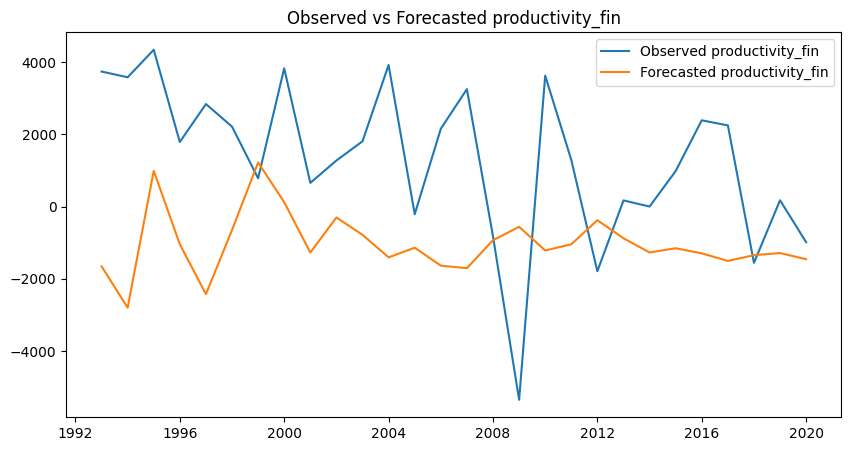

mae : 2817.9062630350636
mse : 11123974.799015211
rmse : 3335.262328365673


In [4]:
# var models (diff)(Finland)

var_models_diff_summary = {}

country = df_names[1]
df_list_updated_cleaned[1].index = pd.date_range(start='1992', periods=len(df_list_updated_cleaned[1]), freq='Y')

model = VAR(df_list_updated_cleaned[1])
results = model.fit(ic='aic')

#デバッグメッセージ
print('DataFrame size:', df_list_updated_cleaned[1].shape)

# 予測を取得する
lag_order = results.k_ar

#デバッグメッセージ
print('Lag order:', lag_order)

forecasted = results.forecast(df_list_updated_cleaned[1].values[-lag_order:], steps=len(df_list_updated_cleaned[1]))

# convert predicted data into dataframe
df_forecasted = pd.DataFrame(forecasted, index=df_list_updated_cleaned[1].index[-len(forecasted):], columns=df_list_updated_cleaned[1].columns)

# plot only first column
first_column = df_list_updated_cleaned[1].columns[0]

plt.figure(figsize=(10,5))
plt.plot(df_list_updated_cleaned[1].index, df_list_updated_cleaned[1][first_column], label='Observed ' + first_column)
plt.plot(df_forecasted.index, df_forecasted[first_column], label='Forecasted ' + first_column)

plt.title(f'Observed vs Forecasted {first_column}')
plt.legend()
plt.show()

# set summary
summary = results.summary()
# append summary onto the dict
var_models_diff_summary[country] = summary

#error indicators
mae = mean_absolute_error(df_list_updated_cleaned[1].iloc[:,0], df_forecasted[first_column])
mse = mean_squared_error(df_list_updated_cleaned[1].iloc[:,0], df_forecasted[first_column])
rmse = np.sqrt(mse)

print(f'mae : {mae}')
print(f'mse : {mse}')
print(f'rmse : {rmse}')

In [ ]:
var_models_diff_summary['Finland']

DataFrame size: (28, 4)
Lag order: 4


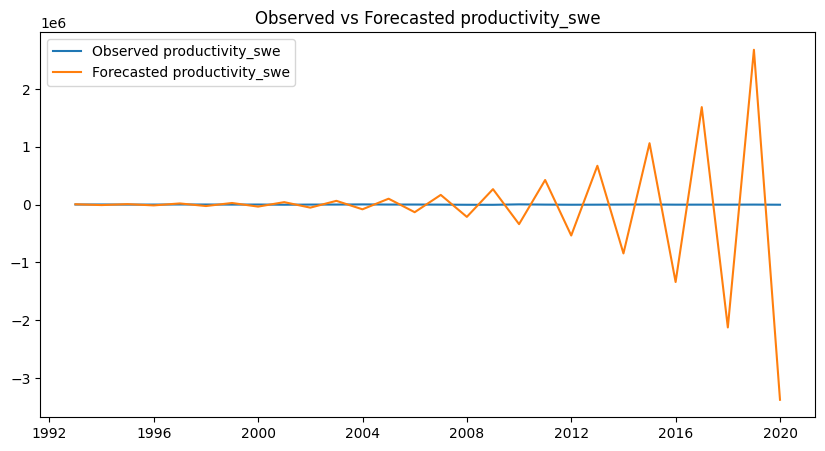

mae : 584068.0379228294
mse : 1098972686171.1263
rmse : 1048318.981117449


In [5]:
# var models (diff)(Sweden)

country = df_names[0]
df_list_updated_cleaned[0].index = pd.date_range(start='1992', periods=len(df_list_updated_cleaned[0]), freq='Y')

model = VAR(df_list_updated_cleaned[0])
results = model.fit(ic='aic')

#デバッグメッセージ
print('DataFrame size:', df_list_updated_cleaned[0].shape)

# 予測を取得する
lag_order = results.k_ar

#デバッグメッセージ
print('Lag order:', lag_order)

forecasted = results.forecast(df_list_updated_cleaned[0].values[-lag_order:], steps=len(df_list_updated_cleaned[0]))

# 予測データをDataFrameに変換
df_forecasted = pd.DataFrame(forecasted, index=df_list_updated_cleaned[0].index[-len(forecasted):], columns=df_list_updated_cleaned[0].columns)

# 最初のカラムだけプロットする
first_column = df_list_updated_cleaned[0].columns[0]

plt.figure(figsize=(10,5))
plt.plot(df_list_updated_cleaned[0].index, df_list_updated_cleaned[0][first_column], label='Observed ' + first_column)
plt.plot(df_forecasted.index, df_forecasted[first_column], label='Forecasted ' + first_column)

plt.title(f'Observed vs Forecasted {first_column}')
plt.legend()
plt.show()

# モデルのサマリーを格納
summary = results.summary()
# 辞書にモデルを追加
var_models_diff_summary[country] = summary

#error indicators
mae = mean_absolute_error(df_list_updated_cleaned[0].iloc[:,0], df_forecasted[first_column])
mse = mean_squared_error(df_list_updated_cleaned[0].iloc[:,0], df_forecasted[first_column])
rmse = np.sqrt(mse)

print(f'mae : {mae}')
print(f'mse : {mse}')
print(f'rmse : {rmse}')

DataFrame size: (28, 4)
Lag order: 4


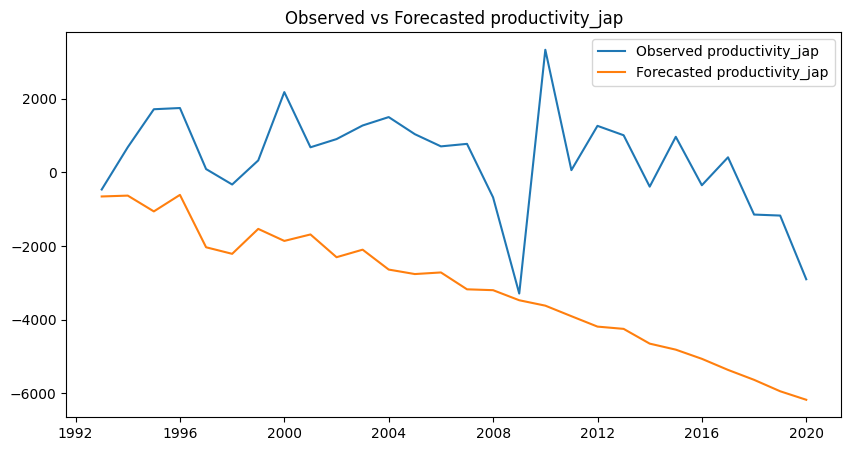

mae : 3505.272259073746
mse : 14898834.693696002
rmse : 3859.900865786063


In [6]:
# var models (diff)(Japan)

country = df_names[2]
df_list_updated_cleaned[2].index = pd.date_range(start='1992', periods=len(df_list_updated_cleaned[2]), freq='Y')

model = VAR(df_list_updated_cleaned[2])
results = model.fit(ic='hqic')

#デバッグメッセージ
print('DataFrame size:', df_list_updated_cleaned[2].shape)

# 予測を取得する
lag_order = results.k_ar

#デバッグメッセージ
print('Lag order:', lag_order)

forecasted = results.forecast(df_list_updated_cleaned[2].values[-lag_order:], steps=len(df_list_updated_cleaned[2]))

# 予測データをDataFrameに変換
df_forecasted = pd.DataFrame(forecasted, index=df_list_updated_cleaned[2].index[-len(forecasted):], columns=df_list_updated_cleaned[2].columns)

# 最初のカラムだけプロットする
first_column = df_list_updated_cleaned[2].columns[0]

plt.figure(figsize=(10,5))
plt.plot(df_list_updated_cleaned[2].index, df_list_updated_cleaned[2][first_column], label='Observed ' + first_column)
plt.plot(df_forecasted.index, df_forecasted[first_column], label='Forecasted ' + first_column)

plt.title(f'Observed vs Forecasted {first_column}')
plt.legend()
plt.show()

# モデルのサマリーを格納
summary = results.summary()
# 辞書にモデルを追加
var_models_diff_summary[country] = summary

#error indicators
mae = mean_absolute_error(df_list_updated_cleaned[2].iloc[:,0], df_forecasted[first_column])
mse = mean_squared_error(df_list_updated_cleaned[2].iloc[:,0], df_forecasted[first_column])
rmse = np.sqrt(mse)

print(f'mae : {mae}')
print(f'mse : {mse}')
print(f'rmse : {rmse}')

In [ ]:
results.k_ar

results.k_ar が0になるのは、通常、モデルの適合時に自動的に選択される最適なラグ数が0と判断された場合です。これは以下のような理由による可能性があります：

データの性質:

データに十分な自己相関がない場合、モデルはラグを必要としないと判断することがあります。
データがランダムウォークの特性を持つか、定常性を満たしていない場合も、適切なラグを見つけることができないかもしれません。
サンプルサイズ:

使用しているサンプルサイズが非常に小さい場合、適切なラグを決定できないことがあります。
モデル選択基準:

fit メソッドで使用される情報基準（例えば、AIC、BICなど）によっては、ラグ0が最も情報量が多いと評価されることがあります。
モデルの仕様:

VARモデルの仕様に問題がある場合、適切なラグ数を特定できない可能性があります。たとえば、変数が過分散であるか、他の形式のモデルがより適している可能性があります。
この問題を解決するためには、以下のステップを試してみてください：

データの前処理を確認してください。データは定常性の条件を満たしている必要があります。非定常データの場合は、差分を取るなどして定常性を満たすように変換してください。
サンプルサイズが十分に大きいことを確認してください。サンプルサイズが小さい場合は、モデルがラグを認識できないことがあります。
モデル選択基準を変更してみてください。ic パラメータを aic から bic や hqic に変えてみるなど、異なる情報基準で最適なラグを探してみてください。
データに含まれる情報の内容を再評価してください。データがモデルに適しているかどうか、または別のモデル（たとえばARIMA）を検討する必要があるかどうかを検討してください。
ラグの最大値を手動で設定してみてください。VAR() 関数の maxlags パラメータを使用して、自動選択に頼らずにラグの数を指定することができます。ただし、これはデータ駆動ではなく、専門家の知識が必要になります。
この情報をもとに、モデルの設定を調整し、再度モデルの適合を試みると良いでしょう。それでも問題が解決しない場合は、データ自体やモデルの適用範囲について慎重に再検討する必要があるかもしれません。






In [ ]:
test = df_list_updated[0].iloc[:,0]
test = np.log(test)
plt.plot(test)